# DeepTremor Time Series Forecasting

This notebook is a template for doing time series forecasting on the Ridgecrest dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)
import py3nvml
py3nvml.grab_gpus(1)

/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/pyth

1

## The Ridgecrest Dataset
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

In [2]:
dataset = np.load('../compressed/full_data.npy')
np.random.shuffle(dataset)

In [3]:
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35680, 15, 60)
After:  (35680, 60, 15)


An observation is recorded every centisecond. This means that, for a single minute, you will have 60000 observations. 

Given a specific sequence, let's say you want to predict the future shaking of the earthquake at the next time point. In order to make this prediction, you choose to use 10 seconds of observations. Thus, you would create a window containing the last 1000 observations to train the model..

Setting seed to ensure reproducibility.

# Parsing in the dataset

In [4]:
def multivariate_data(dataset, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = dataset.shape[1] - target_size
        
    for quake in dataset:

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(quake[indices])

            if single_step:
                labels.append(quake[i+target_size])
            else:
                labels.append(quake[i:i+target_size])

    return np.array(data), np.array(labels)

In [5]:
past_history = 15
future_target = 1
STEP = 1
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)
x_train_single, y_train_single = multivariate_data(dataset[:TRAIN_SPLIT_IDX], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset[TRAIN_SPLIT_IDX:], 0,
                                               None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [6]:
x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape

((1255936, 15, 15), (1255936, 15), (313984, 15, 15), (313984, 15))

# Functions for visualizing data

In [7]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [8]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

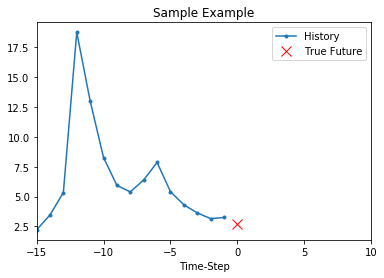

In [9]:
plot = show_plot([x_train_single[0, :, 0], y_train_single[0, 0]], 0, 'Sample Example')
plot.show()

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [10]:
def baseline(history):
    return np.mean(history, axis = 0)

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/matplotlib/pyplot.py'>

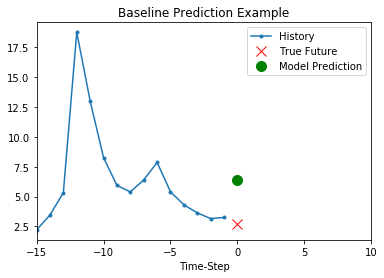

In [11]:
show_plot([x_train_single[0, :, 0], y_train_single[0, 0], baseline(x_train_single[0, :, 0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))


You will see the LSTM requires the input shape of the data it is being given.

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [12]:
# #OPTIONAL CELL (Normalization)
# data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
# data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# dataset = (dataset-data_mean)/data_std

In [14]:
import keras
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
single_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(y_train_single.shape[-1]))

single_step_model.compile(optimizer=tf.keras.optimizers.Adam(0.003), loss=keras.losses.huber_loss)
single_step_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 128)           73728     
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                975       
Total params: 157,135
Trainable params: 157,135
Non-trainable params: 0
_________________________________________________________________


Let's check out a sample prediction.

In [15]:
print(single_step_model.predict(x_val_single[:2]).shape)

(2, 15)


In [16]:
EPOCHS = 10
BATCH_SIZE = 4096
single_step_history = single_step_model.fit(x_train_single, y_train_single, epochs=EPOCHS,
                                            batch_size=BATCH_SIZE,
                                            validation_data=(x_val_single, y_val_single))

Train on 1255936 samples, validate on 313984 samples
Epoch 1/10
1255936/1255936 [==============================] - 71s 57us/sample - loss: 19.5768 - val_loss: 20.6235
Epoch 2/10
1255936/1255936 [==============================] - 70s 56us/sample - loss: 18.8030 - val_loss: 20.2963
Epoch 3/10
1255936/1255936 [==============================] - 69s 55us/sample - loss: 17.7718 - val_loss: 20.3325
Epoch 4/10
1255936/1255936 [==============================] - 70s 56us/sample - loss: 17.3980 - val_loss: 21.7371
Epoch 5/10
1255936/1255936 [==============================] - 69s 55us/sample - loss: 18.5133 - val_loss: 19.9972
Epoch 6/10
1255936/1255936 [==============================] - 70s 56us/sample - loss: 16.6897 - val_loss: 20.1071
Epoch 7/10
1255936/1255936 [==============================] - 69s 55us/sample - loss: 17.0927 - val_loss: 19.7030
Epoch 8/10
1255936/1255936 [==============================] - 70s 55us/sample - loss: 16.7010 - val_loss: 19.4445
Epoch 9/10
1255936/1255936 [=======

In [17]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

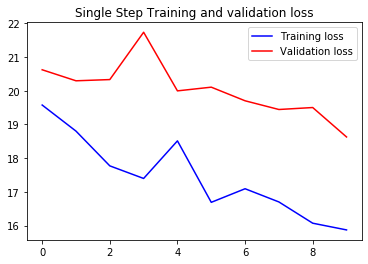

In [18]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

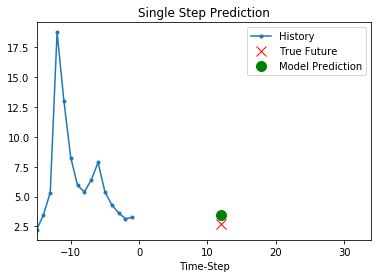

In [19]:
plot = show_plot([x_train_single[0, :, 0], y_train_single[0, 0],
                single_step_model.predict(x_train_single[0:2])[0, 0]], 12,
               'Single Step Prediction')
plot.show()

### Analyze the predictions of the model

In [20]:

y_pred = single_step_model.predict(x_val_single, batch_size = BATCH_SIZE).reshape(-1)
y_true = y_val_single.reshape(-1)
y_pred.shape, y_true.shape

from sklearn import metrics

print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

Explained Variance Score: 0.033705582033505266
Max Error Score: 562566.5566538478
Mean Absolute Error Score: 18.973859939140883
Mean Squared Error Score: 692903.650558273
Median Absolute Error Score: 0.6292576188671957
R2 Score: 0.033464276562049644


### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [117]:
past_history = 15
future_target = 5
STEP = 1
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)

x_train_multi, y_train_multi = multivariate_data(dataset[:TRAIN_SPLIT_IDX], 0,
                                                 None, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset[TRAIN_SPLIT_IDX:],
                                             0, None, past_history,
                                             future_target, STEP)

#Need to reshape y to be 2d
y_train_multi = y_train_multi.reshape(y_train_multi.shape[0], -1)
y_val_multi = y_val_multi.reshape(y_val_multi.shape[0], -1)

print(x_train_multi.shape, y_train_multi.shape, x_val_multi.shape, y_val_multi.shape)

(1141760, 15, 15) (1141760, 75) (285440, 15, 15) (285440, 75)


Let's check out a sample data-point.

In [118]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target earthquake signal to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (15, 15)

 Target earthquake signal to predict : (75,)


Plotting a sample data-point.

In [119]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future[:, 0]), 'b--',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction[:, 0]), 'r--',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

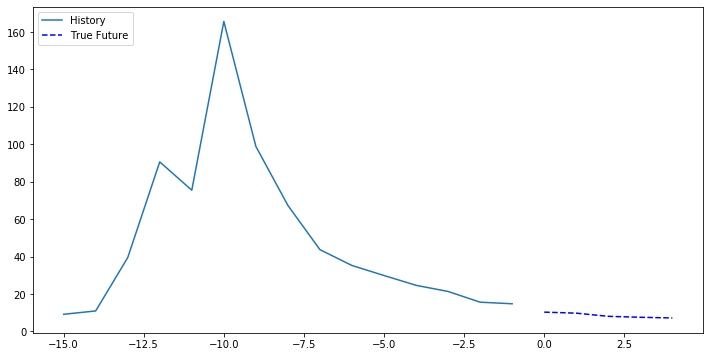

In [120]:
multi_step_plot(x_train_multi[0], y_train_multi[0].reshape(-1, 15), np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers.

In [121]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(y_train_multi.shape[-1]))

multi_step_model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
multi_step_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 15, 64)            20480     
_________________________________________________________________
lstm_23 (LSTM)               (None, 15, 32)            12416     
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 75)                2475      
Total params: 43,691
Trainable params: 43,691
Non-trainable params: 0
_________________________________________________________________


Let's see how the model predicts before it trains.

In [122]:
print(multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).shape)

(285440, 75)


In [123]:
EPOCHS = 10
multi_step_history = multi_step_model.fit(x_train_multi, y_train_multi, epochs=EPOCHS,
                                          validation_data=(x_val_multi, y_val_multi), batch_size = BATCH_SIZE)

Train on 1141760 samples, validate on 285440 samples
Epoch 1/10
1141760/1141760 [==============================] - 50s 44us/sample - loss: 0.7998 - val_loss: 0.3165
Epoch 2/10
1141760/1141760 [==============================] - 46s 40us/sample - loss: 0.2628 - val_loss: 0.2454
Epoch 3/10
1141760/1141760 [==============================] - 46s 40us/sample - loss: 0.2203 - val_loss: 0.2240
Epoch 4/10
1141760/1141760 [==============================] - 46s 40us/sample - loss: 0.2011 - val_loss: 0.2034
Epoch 5/10
1141760/1141760 [==============================] - 45s 40us/sample - loss: 0.1980 - val_loss: 0.1987
Epoch 6/10
1141760/1141760 [==============================] - 46s 40us/sample - loss: 0.1838 - val_loss: 0.1863
Epoch 7/10
1141760/1141760 [==============================] - 46s 40us/sample - loss: 0.1726 - val_loss: 0.1756
Epoch 8/10
1141760/1141760 [==============================] - 49s 43us/sample - loss: 0.1653 - val_loss: 0.1694
Epoch 9/10
1141760/1141760 [=======================

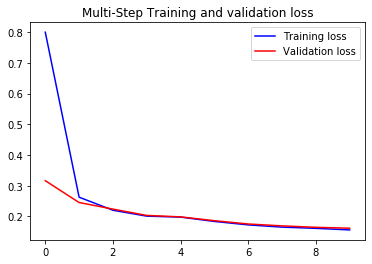

In [124]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

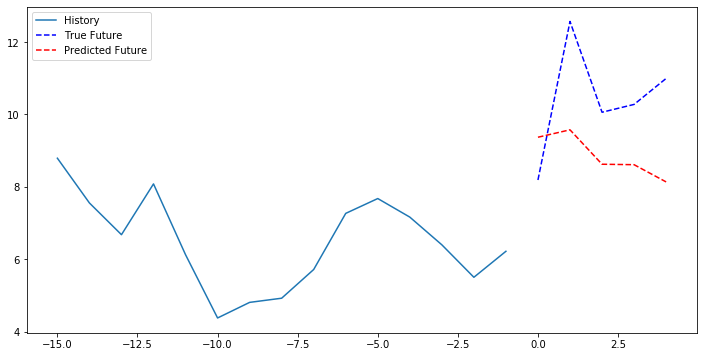

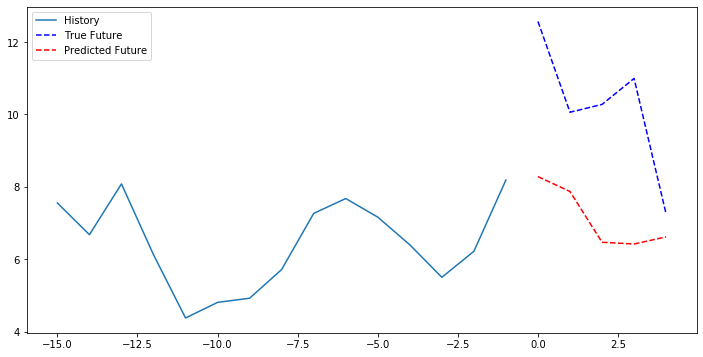

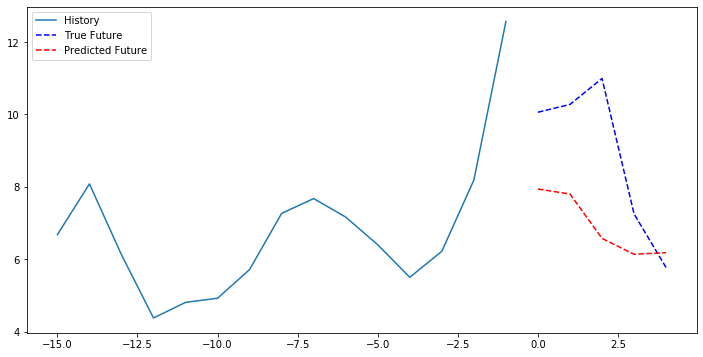

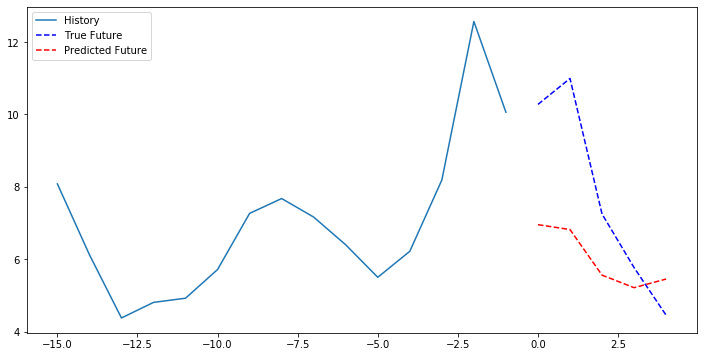

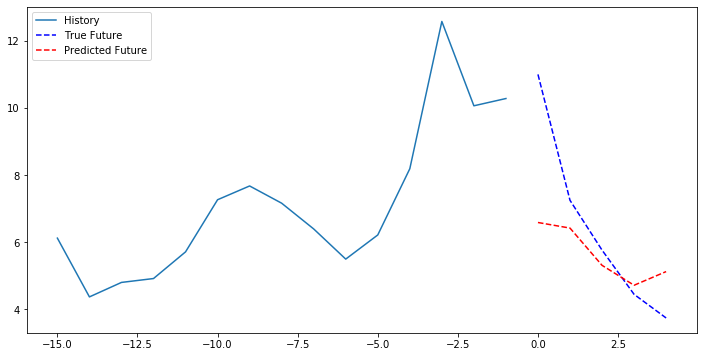

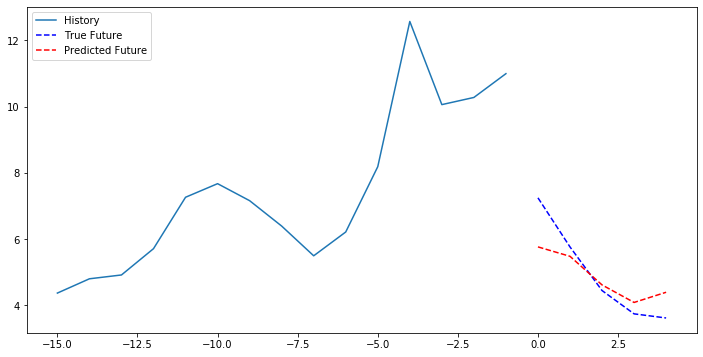

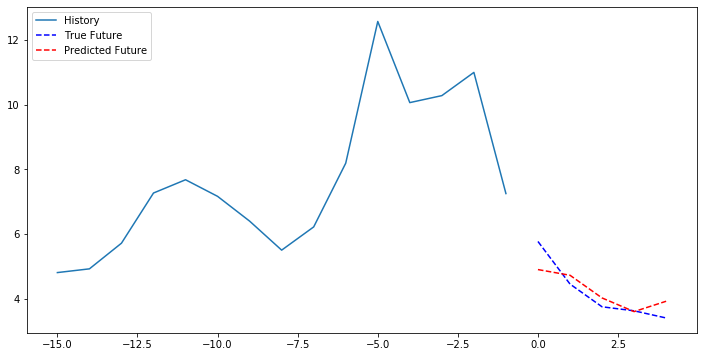

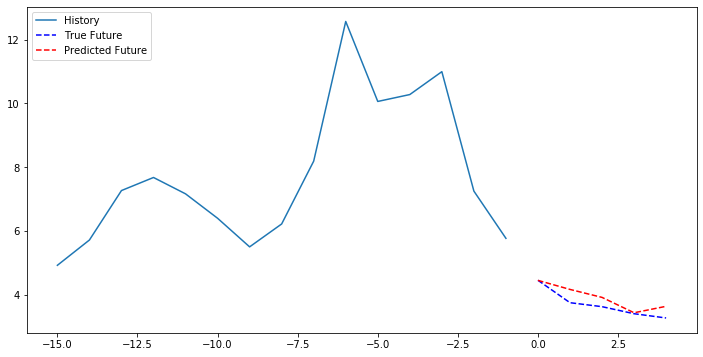

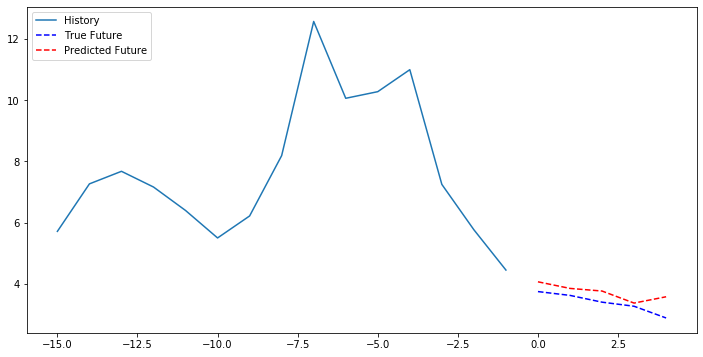

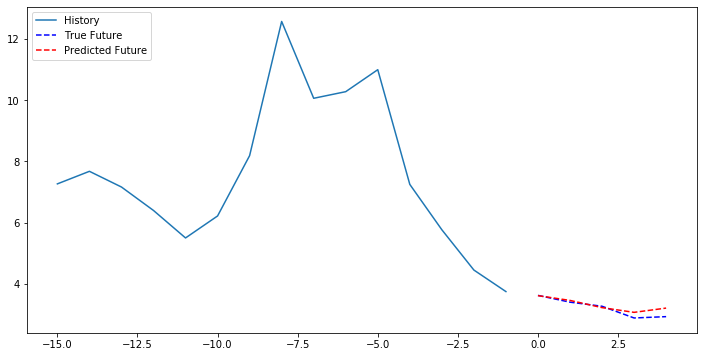

In [126]:
x = x_val_multi[:20]
y = y_val_multi[:20].reshape(len(x), -1, 15)
pred_y = multi_step_model.predict(x).reshape(len(x), -1, 15)
for i in range(10):
    multi_step_plot(x[i], y[i], pred_y[i])

In [129]:
pred_y = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(len(x_val_multi), -1, 15)
pred_y.shape

(285440, 5, 15)

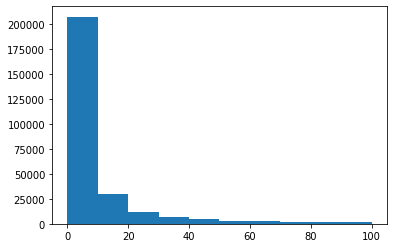

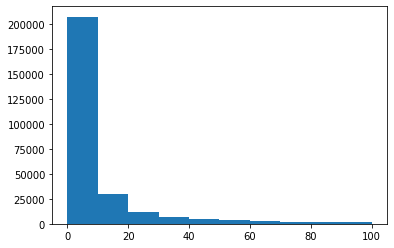

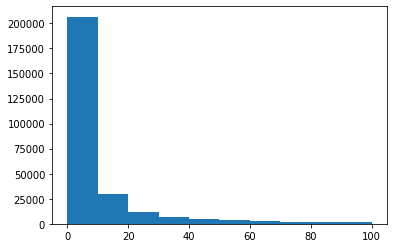

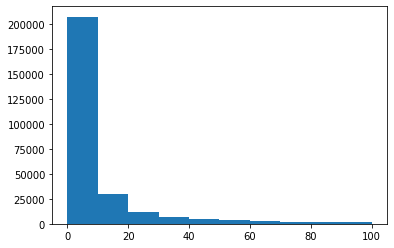

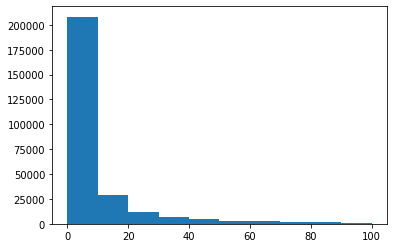

In [136]:
for i in range(5):
    plt.figure()
    data = x_val_multi[:, i, 0]
    data = data[data < 100]
    plt.hist(data)
    plt.show()

# Analyze the predictions of the model

In [144]:
y_pred = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(-1)
y_true = y_val_multi.reshape(-1)
y_pred.shape, y_true.shape

((21408000,), (21408000,))

In [146]:
from sklearn import metrics

print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

Explained Variance Score: 0.14229736639344748
Max Error Score: 221576.9521788197
Mean Absolute Error Score: 15.450592579953222
Mean Squared Error Score: 144645.27205436167
Median Absolute Error Score: 0.5824866241894786
R2 Score: 0.14164780264887555
